# Profile

Nama : Chandra Arifin <br/>
Project : Submission 2 <br/>
Machine Learning (Intermediate)

# Import Libraries

In [4]:
import numpy as np
import pandas as pd
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Baca File dan Hapus Kolom

In [5]:
#variable untuk dipakai di kolom Data Frame
kolomTemp = "Mean Temp (C)"
kolomTgl = "Date/Time"

In [6]:
# baca dataset movies
df = pd.read_csv('Toronto.csv')

In [7]:
#tampilkan record yang ada
df.head()

,Date/Time,Year,Month,Day,Mean Temp (C),Max Temp (C),Min Temp (C),Total Rain (mm),Total Snow (cm),Total Precip (mm),season
0,31-Jan-18,"2,018",1,31,-7.0,2.0,-15.0,0.0,1.0,1.0,Winter
1,30-Jan-18,"2,018",1,30,-11.0,-7.0,-15.0,0.0,0.0,0.0,Winter
2,29-Jan-18,"2,018",1,29,-4.0,-2.0,-7.0,0.0,5.0,5.0,Winter
3,28-Jan-18,"2,018",1,28,1.0,5.0,-3.0,0.0,0.0,0.0,Winter
4,27-Jan-18,"2,018",1,27,5.0,10.0,0.0,2.0,0.0,2.0,Winter


In [8]:
#penghapusan kolom yang tidak dipakai
df = df.drop(columns=['Year',	'Month', 'Day',	'Max Temp (C)',	'Min Temp (C)',
                      'Total Rain (mm)',	'Total Snow (cm)',	'Total Precip (mm)', 'season'])

In [9]:
df.isnull().sum()

Date/Time         0
Mean Temp (C)    13
dtype: int64

In [10]:
#hapus yang N/A
df = df.dropna()

In [11]:
df.duplicated().sum()

0

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2876 entries, 0 to 2888
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date/Time      2876 non-null   object 
 1   Mean Temp (C)  2876 non-null   float64
dtypes: float64(1), object(1)
memory usage: 67.4+ KB


In [13]:
df[kolomTgl]=pd.to_datetime(df[kolomTgl]).dt.date

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2876 entries, 0 to 2888
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date/Time      2876 non-null   object 
 1   Mean Temp (C)  2876 non-null   float64
dtypes: float64(1), object(1)
memory usage: 67.4+ KB


# Pelatihan

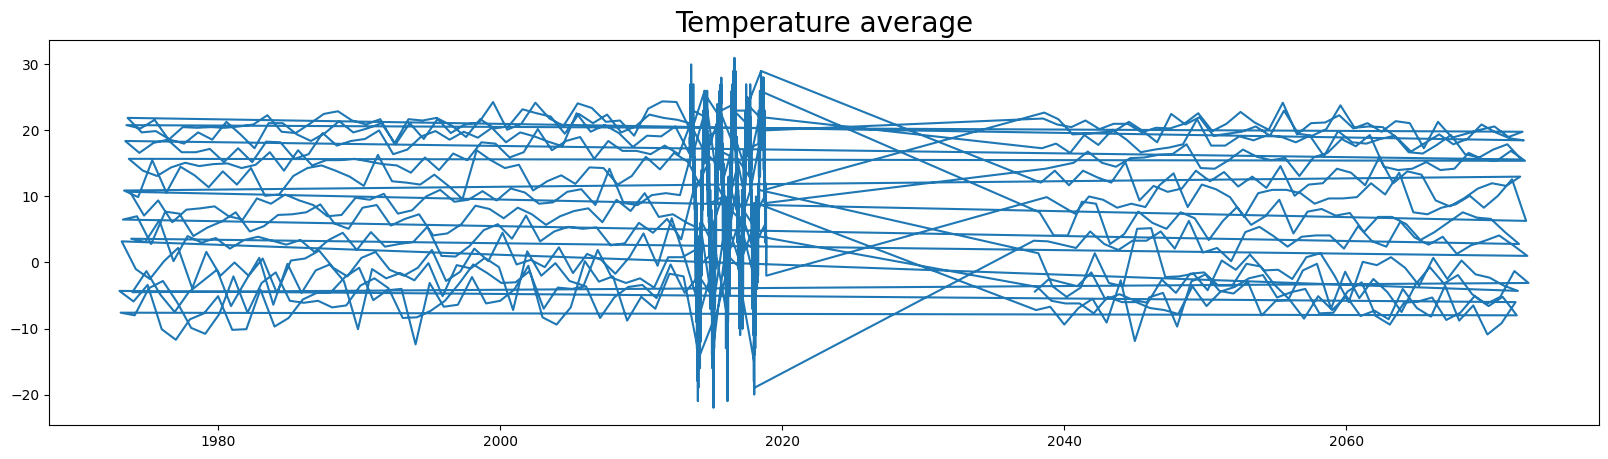

In [15]:
tgl = df[kolomTgl].values
temperatur = df[kolomTemp].values

plt.figure(figsize=(20,5))
plt.plot(tgl, temperatur)
plt.title('Temperature average', fontsize=20);

In [16]:
data_latih, data_test, val_latih, val_test = train_test_split(temperatur, tgl, test_size=0.2, shuffle=False)

In [17]:
print('Jumlah Data Train : ',len(data_latih))
print('Jumlah Data Test : ',len(data_test))
print('Jumlah Value Train : ',len(val_latih))
print('Jumlah Value Test : ',len(val_test))

Jumlah Data Train :  2300
Jumlah Data Test :  576
Jumlah Value Train :  2300
Jumlah Value Test :  576


In [18]:
data_latih

array([ -7., -11.,  -4., ...,  10.,  14.,  13.])

In [19]:
val_latih

array([datetime.date(2018, 1, 31), datetime.date(2018, 1, 30),
       datetime.date(2018, 1, 29), ..., datetime.date(2014, 10, 8),
       datetime.date(2014, 10, 7), datetime.date(2014, 10, 6)],
      dtype=object)


# Pembuatan Callback

In [20]:
threshold_mae = (df[kolomTemp].max() - df[kolomTemp].min()) * 10/100


In [21]:
print(threshold_mae)

5.3


In [22]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae')<threshold_mae and logs.get('val_mae')<threshold_mae):
      print("\nMae model < 10% data")
      self.model.stop_training = True
callbacks = myCallback()

# Pembuatan Model

In [23]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [24]:
data_latih_baru = windowed_dataset(data_latih, window_size=128, batch_size=100, shuffle_buffer=1000)
data_test_baru = windowed_dataset(data_test, window_size=128, batch_size=100, shuffle_buffer=1000)

In [25]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
])

In [26]:
learning_rate = 0.01
decay = 1e-6
momentum = 0.9
nesterov = True
optimizer = tf.keras.optimizers.legacy.SGD (lr=learning_rate, decay=decay, momentum=momentum, nesterov=nesterov)

model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=["mae"])

history = model.fit(data_latih_baru, epochs=100, validation_data=data_test_baru, callbacks=[callbacks], verbose=2)

# history = model.fit(data_latih_baru, epochs=100, verbose=2)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


22/22 - 11s - loss: 9.1621 - mae: 9.6516 - val_loss: 3.8479 - val_mae: 4.3246 - 11s/epoch - 478ms/step
Epoch 2/100
22/22 - 6s - loss: 4.6293 - mae: 5.1082 - val_loss: 5.2983 - val_mae: 5.7798 - 6s/epoch - 251ms/step
Epoch 3/100

Mae model < 10% data
22/22 - 7s - loss: 4.0276 - mae: 4.4994 - val_loss: 3.2696 - val_mae: 3.7335 - 7s/epoch - 310ms/step


# Pembuatan Grafik

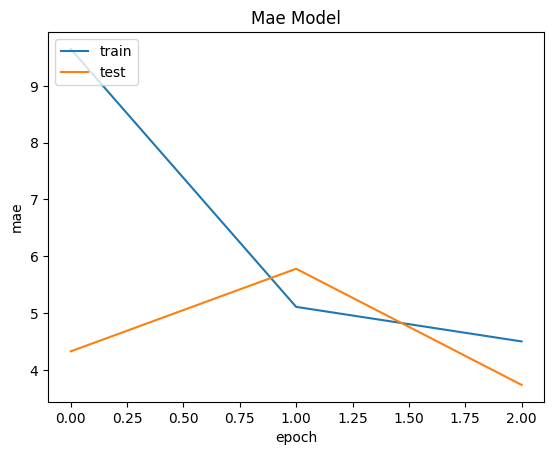

In [27]:
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Mae Model')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

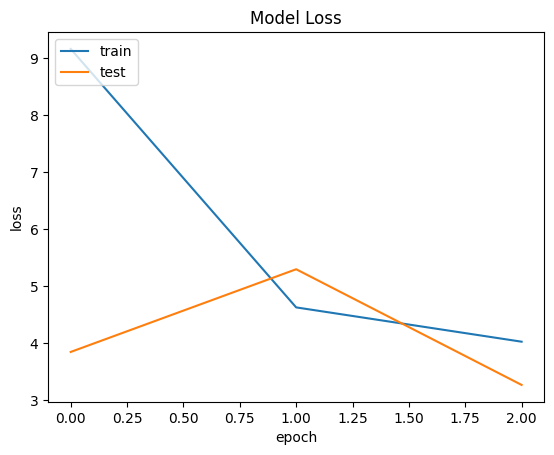

In [28]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()